In [84]:
                          import wandb
import numpy as np
import pandas as pd
import transformers
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torch import nn
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, models
from transformers import BertTokenizer


In [85]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [87]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [88]:
class VQADataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        # Load dataset from CSV
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
        # Initialize the tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Preprocess the dataset
        self.preprocess_dataset()

    def preprocess_dataset(self):
        dataset = load_dataset(
            "csv",
            data_files={
                "train": os.path.join("/kaggle/input/processed-daquar-dataset", "data_train.csv"),
                "test": os.path.join("/kaggle/input/processed-daquar-dataset", "data_eval.csv")
            }
        )

        with open(os.path.join("/kaggle/input/processed-daquar-dataset", "answer_space.txt")) as f:
            answer_space = f.read().splitlines()

        self.data = dataset.map(
            lambda examples: {
                'label': [
                    answer_space.index(ans.replace(" ", "").split(",")[0])
        for ans in examples['answer']
                ]
            },
            batched=True
        )

        # Convert dataset to DataFrame for easy indexing
        self.data = pd.DataFrame(self.data['train'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['image_id']
        question = row['question']
        label = row['label']

        image_path = os.path.join(self.image_folder, f"{image_id}.png")
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize the question
        inputs = self.tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
        # Ensure the tensors are in the correct format for the DataLoader
        input_ids = inputs['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)  # Remove batch dimension

        return image, input_ids, attention_mask, label

In [89]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VQADataset('/kaggle/input/processed-daquar-dataset/data_train.csv', '/kaggle/input/processed-daquar-dataset/images', transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataset = VQADataset('/kaggle/input/processed-daquar-dataset/data_eval.csv', '/kaggle/input/processed-daquar-dataset/images', transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [90]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

class VQAModel(nn.Module):
    def __init__(self, num_answers):
        super(VQAModel, self).__init__()
        # Image feature extractor
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # Question feature extractor
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Fusion and final classification
        self.fc1 = nn.Linear(2048 + 768, 1024)
        self.fc2 = nn.Linear(1024, num_answers)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = checkpoint(self.cnn, images)  # Use checkpointing for ResNet

        # Extract question features
        outputs = checkpoint(self.bert, input_ids, attention_mask)
        question_features = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)

        # Concatenate features
        combined_features = torch.cat((image_features, question_features), dim=1)

        # Classification
        x = self.fc1(combined_features)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [91]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Initialize the model
model = VQAModel(num_answers=582)
model.to(device)

# Training parameters
num_epochs = 10
lr = 0.0005 
weight_decay = 1e-4
best_loss = float('inf')
best_model_state = None
patience = 10  # Number of epochs to wait for improvement before stopping
early_stopping_counter = 0

# Initialize the optimizer and GradScaler for mixed precision training
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define scheduler
scheduler_step_size = int(num_epochs * 0.25)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=scheduler_step_size)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_30/1191064470.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [92]:
def calculate_accuracy(outputs, labels):
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).float().sum()
        accuracy = correct / labels.size(0)
        return accuracy.item()

In [93]:
import torch
from tqdm import tqdm
import wandb

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy.item()

def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, device, num_epochs, patience, save_path, project_name):
    # Initialize wandb
    # wandb.init(project=project_name)
    # wandb.watch(model, log="all")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for images, input_ids, attention_mask, labels in progress_bar:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # with torch.cuda.amp.autocast():
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            running_accuracy += accuracy

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0

        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc="Validating", unit="batch")
            for images, input_ids, attention_mask, labels in val_progress_bar:
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # with torch.cuda.amp.autocast():
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                accuracy = calculate_accuracy(outputs, labels)
                val_running_accuracy += accuracy

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_running_accuracy / len(val_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Training Accuracy: {epoch_accuracy}")
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0  # Reset counter if we get a new best loss
            print(f"Saving model with lowest validation loss: {best_loss:.4f}")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'best_loss': best_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, save_path)
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss for {early_stopping_counter} epochs.")

        # Check for early stopping
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    return metrics

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", unit="batch")
        for images, input_ids, attention_mask, labels in progress_bar:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # with torch.cuda.amp.autocast():
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            running_accuracy += accuracy

    loss = running_loss / len(data_loader)
    accuracy = running_accuracy / len(data_loader)

    print(f"Loss: {loss}, Accuracy: {accuracy}")

    return loss, accuracy


In [94]:
import json

metrics = train_model(model, train_loader, val_loader, criterion, optimizer, scaler, device, num_epochs, patience, "/kaggle/working/best_model.pth", "VQA_BASELINE(ResNet50-Bert)")
with open("/kaggle/working/metrics.json", "w") as f:
    json.dump(metrics, f)

Epoch 1/10:   0%|          | 0/107 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 1/10, Training Loss: 5.102687372225467, Training Accuracy: 0.0741556924637233
Validation Loss: 4.091215726371123, Validation Accuracy: 0.1925578802545494
Saving model with lowest validation loss: 4.0912


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 2/10, Training Loss: 4.213512434023563, Training Accuracy: 0.1489220476039102
Validation Loss: 3.4842597992620736, Validation Accuracy: 0.23716280811300902
Saving model with lowest validation loss: 3.4843


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 3/10, Training Loss: 3.7491767874387936, Training Accuracy: 0.19343404847884846
Validation Loss: 3.100803972404694, Validation Accuracy: 0.2729662277988184
Saving model with lowest validation loss: 3.1008


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 4/10, Training Loss: 3.4544499834007194, Training Accuracy: 0.2175817757009346
Validation Loss: 2.8094619078056833, Validation Accuracy: 0.2895204970769793
Saving model with lowest validation loss: 2.8095


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 5/10, Training Loss: 3.2101825063473712, Training Accuracy: 0.2431765081726502
Validation Loss: 2.5803898116138493, Validation Accuracy: 0.3148497240008595
Saving model with lowest validation loss: 2.5804


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 6/10, Training Loss: 3.050212893530587, Training Accuracy: 0.25663763813883345
Validation Loss: 2.4131940647820445, Validation Accuracy: 0.3337138913502203
Saving model with lowest validation loss: 2.4132


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 7/10, Training Loss: 2.8718342803349004, Training Accuracy: 0.2811703484192073
Validation Loss: 2.2590116028473757, Validation Accuracy: 0.37930118954070263
Saving model with lowest validation loss: 2.2590


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 8/10, Training Loss: 2.7822308050137816, Training Accuracy: 0.28452899327902037
Validation Loss: 2.1032774125304177, Validation Accuracy: 0.4065287809505641
Saving model with lowest validation loss: 2.1033


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 9/10, Training Loss: 2.6407498176966873, Training Accuracy: 0.31385407826610817
Validation Loss: 2.0369874528635328, Validation Accuracy: 0.41146718341613486
Saving model with lowest validation loss: 2.0370


Validating: 100%|██████████| 107/107 [01:59<00:00,  1.12s/batch]


Epoch 10/10, Training Loss: 2.5810821769393493, Training Accuracy: 0.30935375963416056
Validation Loss: 1.904982543994333, Validation Accuracy: 0.45094785484198097
Saving model with lowest validation loss: 1.9050


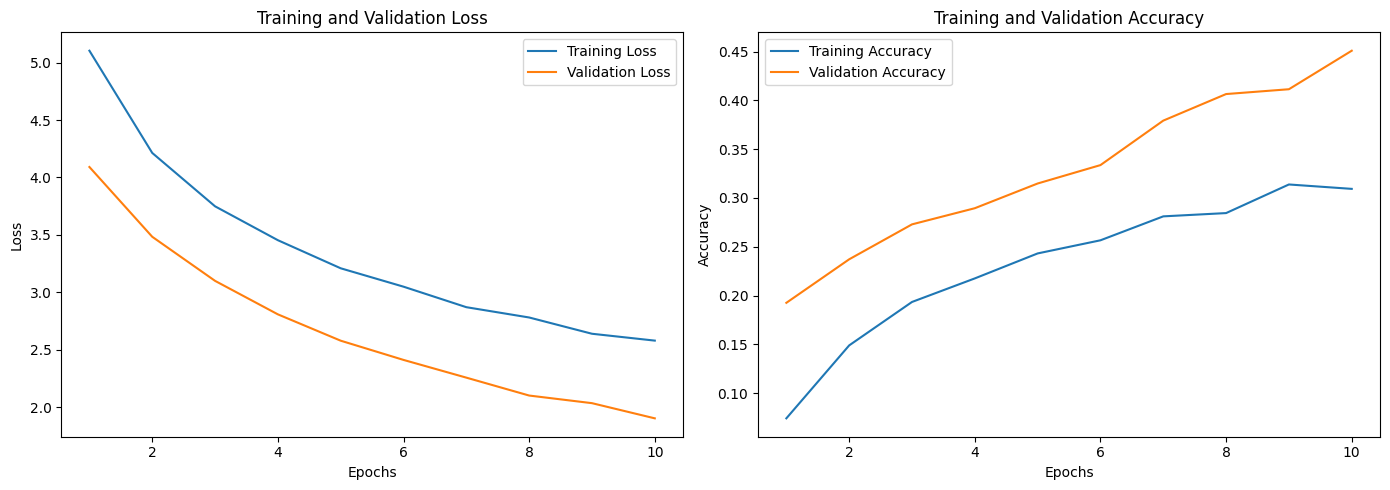

In [95]:
# Plot the result
# Load the saved metrics
with open("/kaggle/working/metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Plot the metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [96]:
class VQAModel_trained(nn.Module):
    def __init__(self, num_answers):
        super(VQAModel_trained, self).__init__()
        # Image feature extractor
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # Question feature extractor
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Fusion and final classification
        self.fc1 = nn.Linear(2048 + 768, 1024)
        self.fc2 = nn.Linear(1024, num_answers)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.cnn(images)

        # Extract question features
        outputs = self.bert(input_ids, attention_mask)
        question_features = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)

        # Concatenate features
        combined_features = torch.cat((image_features, question_features), dim=1)

        # Classification
        x = self.fc1(combined_features)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQAModel_trained(num_answers=582)  # Adjust num_answers based on your dataset
model.to(device)
# Load the best model checkpoint
checkpoint_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print("Best model loaded successfully.")

/tmp/ipykernel_30/2955737378.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Best model loaded successfully.


In [98]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Example usage
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = VQADataset('/kaggle/input/processed-daquar-dataset/data_eval.csv', '/kaggle/input/processed-daquar-dataset/images', transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Test data loader prepared successfully.")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv'

In [ ]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)

In [ ]:
!pip -q install sentence-transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sentence_transformers import SentenceTransformer, util

# Load Sentence-BERT model
model_sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to calculate similarity using Sentence-BERT
def sbert_similarity(sentence1, sentence2):
    embeddings1 = model_sbert.encode(sentence1, convert_to_tensor=True)
    embeddings2 = model_sbert.encode(sentence2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cosine_scores.item()

In [ ]:
def preprocess_answer(answer):
    # Remove underscores from the answer
    return answer.replace('_', ' ')

In [ ]:
# Load answer space for mapping
with open(os.path.join("/kaggle/input/processed-daquar-dataset/images", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

model.eval()
test_losses = []
test_accuracies = []
similarities = []

criterion = nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():
    for idx, (images, input_ids, attention_mask, labels) in enumerate(test_loader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        test_losses.append(loss.item())

        _, preds = torch.max(outputs, 1)
        accuracy = calculate_accuracy(outputs, labels)
        test_accuracies.append(accuracy)

        predicted_answer = preprocess_answer(answer_space[preds.item()])
        actual_answer = preprocess_answer(answer_space[labels.item()])

        similarity = sbert_similarity(predicted_answer, actual_answer)
        similarities.append(similarity)

        # Plotting the image with question and answers
        image = images.cpu().squeeze().permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.imshow(image)
        plt.title(f"Question: {test_dataset.data.iloc[idx]['question']}\nPredicted: {predicted_answer}\nActual: {actual_answer}\nSBERT Similarity: {similarity:.4f}")
        plt.axis('off')
        plt.show()

        if idx >= 49:  # Display only 50 samples
            break

# Print average similarity score
average_similarity = np.mean(similarities)
print(f"Average SBERT Similarity: {average_similarity:.4f}")

In [ ]:
# Plot test accuracy and test loss
plt.figure(figsize=(14, 6))

# Test Loss
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

In [ ]:
# Similarity
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(similarities, label='SBERT Similarity')
plt.xlabel('Batch')
plt.ylabel('Similarity')
plt.title('SBERT Similarity')
plt.legend()
plt.show()